References:

[COVID Trends Created by Aatish Bhatia in collaboration with Minute Physics][1]

Data sources:

[都道府県別新型コロナウイルス感染者数マップ（ジャッグジャパン株式会社提供) - Dashboard & Map of COVID-19 Japan Case (2019-nCoV)][2]

[2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE][3]

[1]:https://aatishb.com/covidtrends/

[2]:https://gis.jag-japan.com/covid19jp/

[3]:https://github.com/CSSEGISandData/COVID-19

In [1]:
#ignore warning messages
import warnings
warnings.filterwarnings('ignore')

#import packages
import optuna
import datetime
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.pylab import rcParams
plt.style.use('seaborn-colorblind')
%matplotlib inline
%load_ext autotime

jp_patients = 'https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'
df_japan = pd.read_csv(jp_patients)

df_japan['Date'] = pd.to_datetime(df_japan['確定日'], infer_datetime_format=True)
display(df_japan)


,通し,厚労省NO,無症状病原体保有者,国内,チャーター便,年代,性別,確定日,発症日,受診都道府県,...,更新日時,Field2,Field4,Field5,Field6,Field7,Field8,Field9,Field10,Date
0,1,1,NaN,A-1,NaN,30,男性,1/15/2020,1/3/2020,神奈川県,...,4/6/2020 11:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-15
1,2,2,NaN,A-2,NaN,40,男性,1/24/2020,1/14/2020,東京都,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-24
2,3,3,NaN,A-3,NaN,30,女性,1/25/2020,1/21/2020,東京都,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-25
3,4,4,NaN,A-4,NaN,40,男性,1/26/2020,1/23/2020,愛知県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-26
4,5,5,NaN,A-5,NaN,40,男性,1/28/2020,1/22/2020,愛知県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854,3855,NaN,NaN,NaN,NaN,20,男性,4/6/2020,NaN,沖縄県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-06
3855,3856,NaN,NaN,NaN,NaN,20,男性,4/6/2020,NaN,沖縄県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-06
3856,3857,NaN,NaN,NaN,NaN,50,男性,4/6/2020,NaN,沖縄県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-06
3857,3858,NaN,NaN,NaN,NaN,50,女性,4/6/2020,NaN,沖縄県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-06


In [2]:
df_japan_new = df_japan.copy()
df_japan_new = df_japan_new.rename(columns={'通し': 'No', '年代': 'Age', '性別': 'Sex', '受診都道府県': 'Pref', '人数': 'Count'})
df_japan_new = df_japan_new.set_index('Date')
display(df_japan_new)


,No,厚労省NO,無症状病原体保有者,国内,チャーター便,Age,Sex,確定日,発症日,Pref,...,居住都道府県コード,更新日時,Field2,Field4,Field5,Field6,Field7,Field8,Field9,Field10
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-15,1,1,NaN,A-1,NaN,30,男性,1/15/2020,1/3/2020,神奈川県,...,14.0,4/6/2020 11:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,2,2,NaN,A-2,NaN,40,男性,1/24/2020,1/14/2020,東京都,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,3,3,NaN,A-3,NaN,30,女性,1/25/2020,1/21/2020,東京都,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,4,4,NaN,A-4,NaN,40,男性,1/26/2020,1/23/2020,愛知県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,5,5,NaN,A-5,NaN,40,男性,1/28/2020,1/22/2020,愛知県,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-06,3855,NaN,NaN,NaN,NaN,20,男性,4/6/2020,NaN,沖縄県,...,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-06,3856,NaN,NaN,NaN,NaN,20,男性,4/6/2020,NaN,沖縄県,...,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-06,3857,NaN,NaN,NaN,NaN,50,男性,4/6/2020,NaN,沖縄県,...,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 38.1 ms


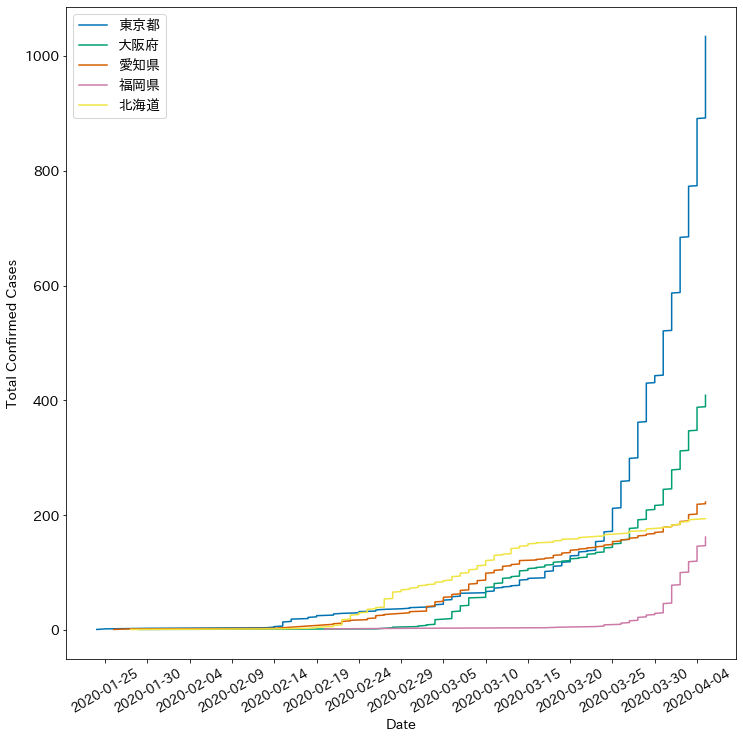

time: 523 ms


In [3]:
#df_pref_list = df_japan_new.Pref.unique()
pref_select = ['東京都', '大阪府', '愛知県', '福岡県', '北海道']

rcParams["font.size"] = 14
rcParams['figure.figsize'] = 12, 12
fig, ax = plt.subplots()

#for pref in df_pref_list:
for pref in pref_select:
    ax.plot(df_japan_new[df_japan_new.Pref == pref]['Count'].cumsum())

ax.legend(pref_select, loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('Total Confirmed Cases')
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=5, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
xlabels = ax.get_xticklabels()
plt.setp(xlabels, rotation=30, fontsize=13)
fig.align_labels()
plt.show()


In [4]:
group = df_japan_new[df_japan_new.Pref == '東京都'].groupby('Date')
df_group = group.sum()

df_group_interpolated = df_group.resample('D').interpolate('time')

df_group_interpolated['DailyCumsum'] = df_group_interpolated['Count'].cumsum()
#df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].rolling(window=7).sum()
df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].ewm(span=7).mean()*7

display(df_group_interpolated)


,No,市町村内症例番号,Count,死者合計,退院数累計,退院数,発症数,PCR検査実施人数,X,Y,...,居住都道府県コード,Field4,Field5,Field6,Field7,Field8,Field9,Field10,DailyCumsum,WeeklySum
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-24,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,116.409685,39.903832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.000000
2020-01-25,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,116.409685,39.903832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.000000
2020-01-26,4.8,0.0,1.0,0.0,0.0,0.0,1.6,0.0,116.409685,39.903832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.000000
2020-01-27,6.6,0.0,1.0,0.0,0.0,0.0,1.2,0.0,116.409685,39.903832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.000000
2020-01-28,8.4,0.0,1.0,0.0,0.0,0.0,0.8,0.0,116.409685,39.903832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,154143.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,9219.648702,2355.486210,...,858.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,635.0,364.216203
2020-04-02,254431.0,0.0,97.0,0.0,0.0,0.0,0.0,0.0,13550.089759,3461.850945,...,1261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,732.0,442.912153
2020-04-03,259702.0,0.0,89.0,0.0,0.0,0.0,0.0,0.0,12432.556583,3176.337465,...,1157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,821.0,487.934115


time: 59.4 ms


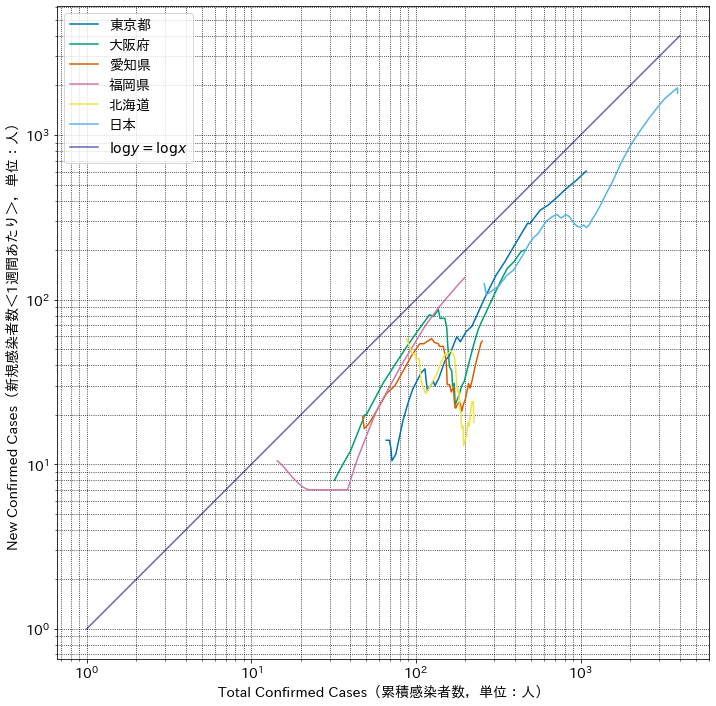

time: 1.06 s


In [14]:
x = np.arange(1, 4000)
y = np.arange(1, 4000)

day_from = '2020-02-28'

str_japan = '日本'

#jp_pref_list = df_japan_new.Pref.unique()
jp_pref_select = ['東京都', '大阪府', '愛知県', '福岡県', '北海道']

rcParams["font.size"] = 14
rcParams['figure.figsize'] = 12, 12
fig, ax = plt.subplots()

#for pref in jp_pref_list:
for pref in jp_pref_select + [str_japan]:
    
    if pref in jp_pref_select:
    
        group = df_japan_new[df_japan_new.Pref == pref].groupby('Date')
        df_group = group.sum()

        df_group_interpolated = df_group.resample('D').interpolate('time')

        df_group_interpolated['DailyCumsum'] = df_group_interpolated['Count'].cumsum()
        df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].rolling(window=7).sum()
        #df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].ewm(span=7).mean()*7

        df_group_trim = df_group_interpolated[df_group_interpolated.index >= day_from]

        ax.plot(df_group_trim['DailyCumsum'], df_group_trim['WeeklySum'])
        
    else:
        
        group = df_japan_new.groupby('Date')
        df_group = group.sum()

        df_group_interpolated = df_group.resample('D').interpolate('time')

        df_group_interpolated['DailyCumsum'] = df_group_interpolated['Count'].cumsum()
        df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].rolling(window=7).sum()
        #df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].ewm(span=7).mean()*7

        df_group_trim = df_group_interpolated[df_group_interpolated.index >= day_from]

        ax.plot(df_group_trim['DailyCumsum'], df_group_trim['WeeklySum'])
    
ax.plot(x, y, color = 'navy', alpha = 0.6)
ax.legend(jp_pref_select + [str_japan] + ['$\log y = \log x$'])
ax.set_xlabel('Total Confirmed Cases（累積感染者数，単位：人）')
ax.set_ylabel('New Confirmed Cases（新規感染者数＜1週間あたり＞，単位：人）')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which='major',color='black',linestyle=':')
ax.grid(which='minor',color='black',linestyle=':')
ax.set_aspect('equal', 'box')
fig.align_labels()
plt.show()


In [6]:
us_patients = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

df_us = pd.read_csv(us_patients)

display(df_us)


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,51,55,56,58,69,77,82,84,93,112
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,0,2,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,79,100,127,174,239,286,316,316,452,475
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,19,22,0,0,30,30,30,37,40,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,84090053,US,USA,840,90053.0,Unassigned,Washington,US,0.0000,0.0000,...,67,0,125,274,274,303,344,501,483,533
3249,84090054,US,USA,840,90054.0,Unassigned,West Virginia,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3250,84090055,US,USA,840,90055.0,Unassigned,Wisconsin,US,0.0000,0.0000,...,61,0,0,0,0,0,0,0,0,0
3251,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0


time: 506 ms


In [7]:
us_state_list = df_us.Province_State.unique()

display(us_state_list)


array(['American Samoa', 'Guam', 'Northern Mariana Islands',
       'Puerto Rico', 'Virgin Islands', 'Alabama', 'Alaska', 'Arizona',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Diamond Princess',
       'Grand Princess'], dtype=object)

time: 2.56 ms


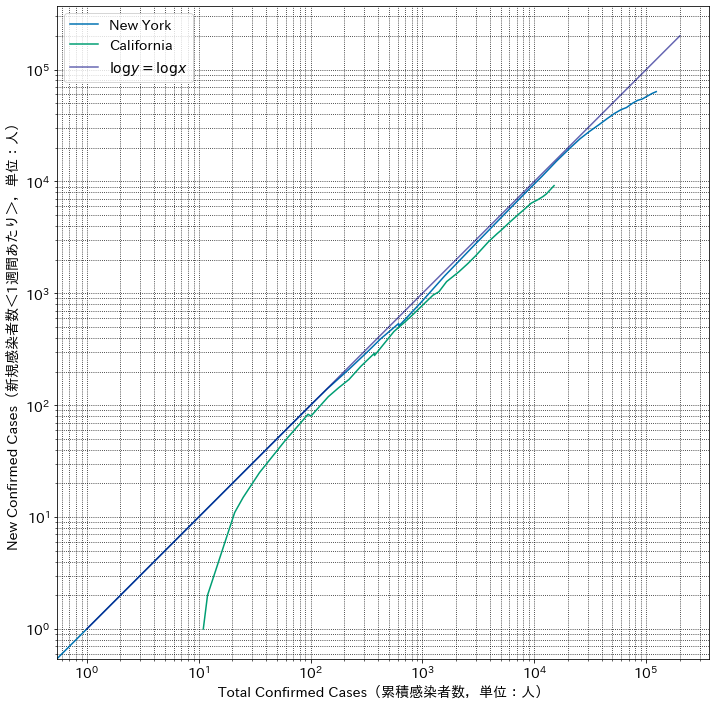

time: 1.51 s


In [8]:
df_us_new = df_us.copy()

x = np.arange(1, 200000)
y = np.arange(1, 200000)

day_from = '2020-02-28'

#us_state_list = df_us.Province_State.unique()
us_state_select = ['New York', 'California']

rcParams["font.size"] = 14
rcParams['figure.figsize'] = 12, 12
fig, ax = plt.subplots()

#for state in us_state_list:
for state in us_state_select:
    
    df_state = df_us_new[df_us_new.Province_State == state].transpose()
    
    df_state_trim = df_state.iloc[11:, :]
    df_state_trim.columns = df_state.iloc[6, :]

    df_state_trim['Date'] = pd.to_datetime(df_state_trim.index, infer_datetime_format=True)
    df_state_trim = df_state_trim.set_index('Date')
    
    df_state_cumsum = df_state_trim.sum(axis=1)
    
    group = df_state_cumsum.groupby('Date')
    df_group = pd.DataFrame(group.sum())
    df_group.columns = ['DailyCumsum']

    df_group_interpolated = df_group.resample('D').interpolate('time')
    
    df_group_interpolated['WeeklySum'] = df_group_interpolated['DailyCumsum'].diff(7)
    
    df_group_trim = df_group_interpolated[df_group_interpolated.index >= day_from]
    
    ax.plot(df_group_trim['DailyCumsum'], df_group_trim['WeeklySum'])
    
ax.plot(x, y, color = 'navy', alpha = 0.6)
ax.legend(us_state_select + ['$\log y = \log x$'])
ax.set_xlabel('Total Confirmed Cases（累積感染者数，単位：人）')
ax.set_ylabel('New Confirmed Cases（新規感染者数＜1週間あたり＞，単位：人）')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which='major',color='black',linestyle=':')
ax.grid(which='minor',color='black',linestyle=':')
ax.set_aspect('equal', 'box')
fig.align_labels()
plt.show()

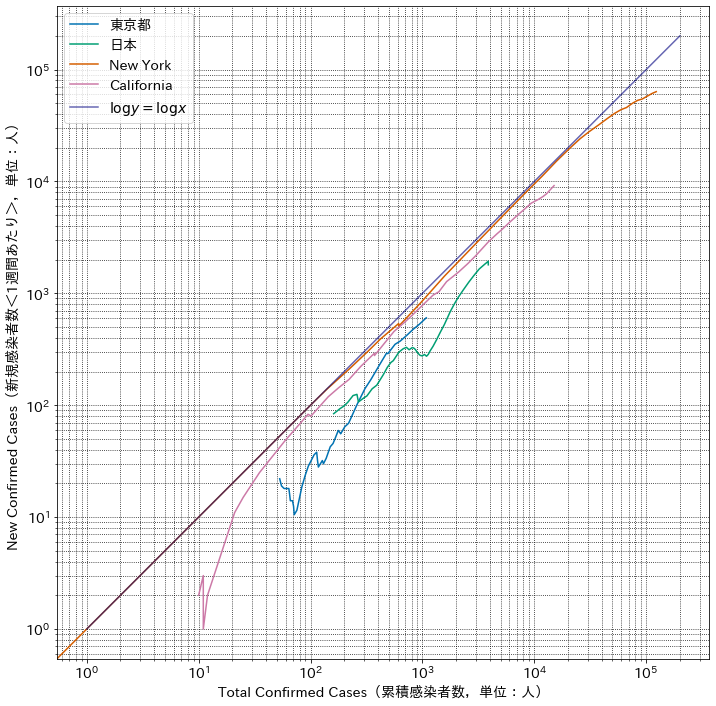

time: 1.39 s


In [15]:
x = np.arange(1, 200000)
y = np.arange(1, 200000)

day_from = '2020-02-22'

jp_pref_select = ['東京都']
combined_state = jp_pref_select + [str_japan] + us_state_select 

rcParams["font.size"] = 14
rcParams['figure.figsize'] = 12, 12
fig, ax = plt.subplots()

for state in combined_state:
    
    if state in jp_pref_select:
    
        group = df_japan_new[df_japan_new.Pref == state].groupby('Date')
        df_group = group.sum()

        df_group_interpolated = df_group.resample('D').interpolate('time')

        df_group_interpolated['DailyCumsum'] = df_group_interpolated['Count'].cumsum()
        df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].rolling(window=7).sum()
        #df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].ewm(span=7).mean()*7

        df_group_trim = df_group_interpolated[df_group_interpolated.index >= day_from]

        ax.plot(df_group_trim['DailyCumsum'], df_group_trim['WeeklySum'])
        
    elif state == str_japan:
        
        group = df_japan_new.groupby('Date')
        df_group = group.sum()

        df_group_interpolated = df_group.resample('D').interpolate('time')

        df_group_interpolated['DailyCumsum'] = df_group_interpolated['Count'].cumsum()
        df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].rolling(window=7).sum()
        #df_group_interpolated['WeeklySum'] = df_group_interpolated['Count'].ewm(span=7).mean()*7

        df_group_trim = df_group_interpolated[df_group_interpolated.index >= day_from]

        ax.plot(df_group_trim['DailyCumsum'], df_group_trim['WeeklySum'])
        
    else:
        
        df_state = df_us_new[df_us_new.Province_State == state].transpose()
    
        df_state_trim = df_state.iloc[11:, :]
        df_state_trim.columns = df_state.iloc[6, :]

        df_state_trim['Date'] = pd.to_datetime(df_state_trim.index, infer_datetime_format=True)
        df_state_trim = df_state_trim.set_index('Date')

        df_state_cumsum = df_state_trim.sum(axis=1)

        group = df_state_cumsum.groupby('Date')
        df_group = pd.DataFrame(group.sum())
        df_group.columns = ['DailyCumsum']

        df_group_interpolated = df_group.resample('D').interpolate('time')

        df_group_interpolated['WeeklySum'] = df_group_interpolated['DailyCumsum'].diff(7)

        df_group_trim = df_group_interpolated[df_group_interpolated.index >= day_from]

        ax.plot(df_group_trim['DailyCumsum'], df_group_trim['WeeklySum'])
        
    
ax.plot(x, y, color = 'navy', alpha = 0.6)
ax.legend(combined_state + ['$\log y = \log x$'])
ax.set_xlabel('Total Confirmed Cases（累積感染者数，単位：人）')
ax.set_ylabel('New Confirmed Cases（新規感染者数＜1週間あたり＞，単位：人）')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which='major',color='black',linestyle=':')
ax.grid(which='minor',color='black',linestyle=':')
ax.set_aspect('equal', 'box')
fig.align_labels()
plt.show()
